## Model

Assume there's a measure for malignancy, denoted as $X\in[0,1]$, this measure is specific to a type of cancer and its relapse. We hypothesize there's a latent mapping from MRI images to this $X$, which can be extract from patches $P\in\mathbb{R}^{16\times16}$.

We search for this latent mapping by extracting various features from $16\times 16$ patches extracted from primary tumor, non-tumor tissues, and local recurrent. We model the distribution of $X$ as follow:

```mermaid
flowchart
    PTV[Primary Tumor]
    NT[Non-tumor]
    Re[Local Recurrent Tumor]
    PTV <--> |Similar|Re
    PTV <--> |Different|NT
    Re <--> |Different|NT
```

Naturally, 


In [1]:
import pandas as pd
import numpy as np
import SimpleITK as sitk
from IPython.display import *
from pprint import pprint, pformat
from typing import *
import warnings
from tqdm.auto import tqdm
warnings.filterwarnings('ignore', category=pd.errors.PerformanceWarning)

In [2]:
elligible_patients = ['FU3','FU93','FU109','FU185','FU218','FU293','FU485','FU585','NPCR001','NPCR006','NPCR009','NPCR014']
elligible_patients = set([f'/{idx}' for idx in elligible_patients])

# {'PID': (df_pre, df_post)}
df_dict = {}

with pd.HDFStore("../patch_textures/Pre-CE-T1W-FS_TRA-OneSlice-v4.h5") as pre_hd_file, \
    pd.HDFStore("../patch_textures/Post-CE-T1W-FS_TRA-OneSlice-v4.h5") as post_hd_file:
    idlist_pre = set(pre_hd_file.keys())
    idlist_post = set(post_hd_file.keys())
    print(f"{idlist_pre = }")
    print(f"{idlist_post = }")

    overlap = idlist_pre & idlist_post
    overlap = overlap & elligible_patients
    if overlap != elligible_patients:
        msg = f"Some patients are missing: \n\t{elligible_patients = } \n\t{overlap = }"
        raise ValueError(msg)
    overlap = list(overlap)
    overlap.sort()
    


    for test_case in overlap:
        df_dict[test_case.lstrip('/')] = (pre_hd_file.get(test_case), post_hd_file.get(test_case)) 


idlist_pre = {'/FU68', '/FU293', '/FU396', '/FU218', '/NPCR008', '/FU136', '/NPCR029', '/FU340', '/NPCR010', '/NPCR028', '/NPCR012', '/FU316', '/NPCR038', '/NPCR002', '/FU585', '/NPCR005', '/NPCR024', '/NPCR035', '/NPCR009', '/NPCR007', '/FU3', '/NPCR027', '/FU135', '/FU101', '/NPCR032', '/NPCR004', '/NPCR026', '/NPCR023', '/FU485', '/FU207', '/NPCR022', '/NPCR037', '/FU109', '/NPCR017', '/FU283', '/FU560', '/FU185', '/NPCR001', '/NPCR006', '/NPCR014', '/NPCR015', '/FU90', '/FU142', '/NPCR036', '/NPCR031', '/FU187', '/NPCR013', '/FU354', '/NPCR011', '/FU93', '/FU380', '/FU147'}
idlist_post = {'/NPCR009', '/FU485', '/FU109', '/FU121', '/FU293', '/FU354', '/FU93', '/FU3', '/FU218', '/FU185', '/FU557', '/NPCR001', '/NPCR006', '/NPCR014', '/NPCR015', '/FU207', '/FU585'}


# Statistical analysis

Patches can be catgorized as having three types, primary tumor (pNPC), recurrent tumor (rNPC) and other non-tumor tissues. Here we replace non-tumour tissues with vicinity patches as its very difficult to draw a clear margin, therefore, we create a belt with a fixed distant from the edge of the pNPC/rNPC segmentation and draw extract patches from it.

## Analysis model

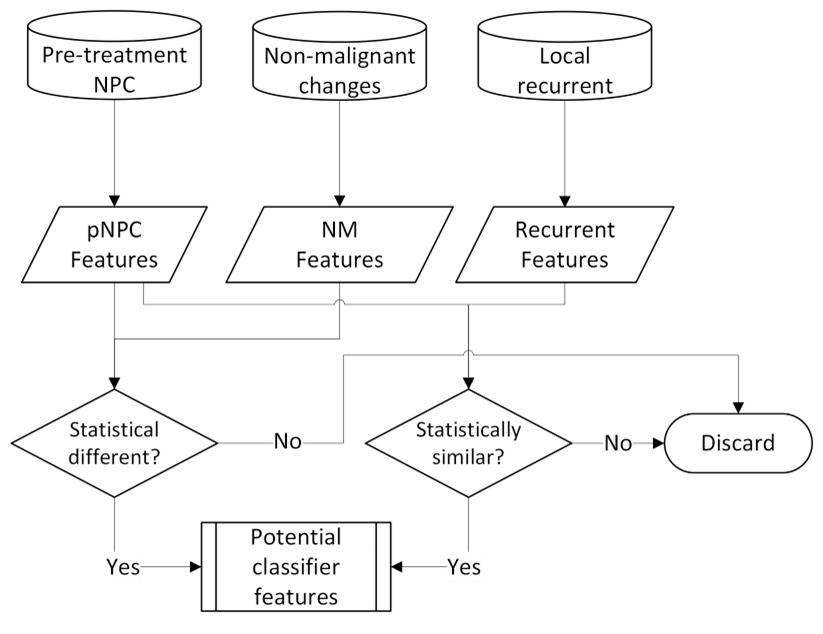


In [3]:
from scipy.stats import ttest_ind, mannwhitneyu, normaltest
from functools import partial
import re
warnings.filterwarnings('ignore', category=RuntimeWarning)
warnings.filterwarnings('ignore', category=FutureWarning)

# -- for each feature, performs independent t-test
def feature_compare(pNPC_feat: pd.DataFrame, 
                    rNPC_feat: pd.DataFrame, 
                    others_feat: pd.DataFrame, 
                    trim: Optional[float] = 0.1) -> List[pd.Series]:
    rows = []
    
    # Test if features are normally distributed
    all_feats = np.concatenate([pNPC_feat.values, rNPC_feat.values, others_feat.values], axis=0)
    norm_stat, norm_pval = normaltest(all_feats, nan_policy='omit')
    if norm_pval < .05:
        # Use non-parametric test if features are not normally distributed
        stat_func = mannwhitneyu
    else:
        # Otherwise use regular independent sampled t-test
        stat_func = partial(ttest_ind, trim=trim)
    
    # * t-test between rNPC and pNPC features, we want similar features
    f, pval = stat_func(pNPC_feat.values.astype('float'), rNPC_feat.values.astype('float'))
    row = pd.Series({
        'pval': pval, 
        'f': f
    }, name=('pNPC vs rNPC', *feat))
    rows.append(row)
    
    # * t-test bewteen pNPC and others
    f, pval = stat_func(pNPC_feat.values.astype('float'), others_feat.values.astype('float'))
    row = pd.Series({
        'pval': pval, 
        'f': f
    }, name=('pNPC vs Others', *feat))
    rows.append(row)
    
    # * t-test bewteen rNPC and others
    f, pval = stat_func(rNPC_feat.values.astype('float'), others_feat.values.astype('float'))
    row = pd.Series({
        'pval': pval, 
        'f': f
    }, name=('rNPC vs Others', *feat))
    rows.append(row)
    return rows

vic_status_idx = ('Extract Parameters', 'Flags', 'Vicinity')
fit_features = {}
for pid, (df_pre_raw, df_post_raw) in tqdm(df_dict.items(), total=len(df_dict)):
    df_pre = df_pre_raw.drop(['diagnostics'], axis=1)
    df_post = df_post_raw.drop(['diagnostics'], axis=1)
    rows = []
    for feat in df_pre:
        # Skip metadata columns
        skip = r"(?i).*(diagnostics|extract parameters).*"
        if mo := re.search(skip, '_'.join(feat)):
            continue
        
        # df_pre[vic_status_idx].fillna(False)
        pNPC_feat = df_pre[feat][~df_pre[vic_status_idx]].astype('float')
        rNPC_feat = df_post[feat][~df_post[vic_status_idx]].astype('float')
        others_feat = pd.concat([df_pre[feat][df_pre[vic_status_idx]], df_post[feat][df_post[vic_status_idx]]]).astype('float')
        
        res = feature_compare(pNPC_feat, rNPC_feat, others_feat, trim=0)
        rows.extend(res)

    # * form dataframe for statistics
    df_stat = pd.concat(rows, axis=1).T 
    df_stat.sort_index(level=0, inplace=True)
    df_stat = df_stat.unstack(level=0)
    df_stat = df_stat.swaplevel(0, 1, axis=1).sort_index(axis=1, level=0)
    
    # * form criteria
    criteria = (df_stat[('pNPC vs rNPC', 'pval')].abs() > .05) \
    * (df_stat['pNPC vs Others', 'pval'] < .05) \
    * (df_stat['rNPC vs Others', 'pval'] < .05)
    fit_features[pid] = set(df_stat[criteria].index)
    print(f"[{pid:^5}] Number of features fits criteria: {len(fit_features[pid]):<3} | "
          f"pre # samples: {len(df_pre):<5} (+ve = {(~df_pre[vic_status_idx]).sum():<5}) | "
          f"post # samples: {len(df_post):<5} (+ve = {(~df_post[vic_status_idx]).sum():<5})")

  0%|          | 0/12 [00:00<?, ?it/s]

[FU109] Number of features fits criteria: 5   | pre # samples: 2747  (+ve = 1747 ) | post # samples: 4259  (+ve = 1259 )
[FU185] Number of features fits criteria: 20  | pre # samples: 1203  (+ve = 203  ) | post # samples: 1032  (+ve = 32   )
[FU218] Number of features fits criteria: 39  | pre # samples: 1030  (+ve = 30   ) | post # samples: 1335  (+ve = 335  )
[FU293] Number of features fits criteria: 3   | pre # samples: 1260  (+ve = 260  ) | post # samples: 1007  (+ve = 7    )
[ FU3 ] Number of features fits criteria: 18  | pre # samples: 5903  (+ve = 4903 ) | post # samples: 1697  (+ve = 697  )
[FU485] Number of features fits criteria: 15  | pre # samples: 1880  (+ve = 880  ) | post # samples: 2306  (+ve = 306  )
[FU585] Number of features fits criteria: 27  | pre # samples: 2993  (+ve = 1993 ) | post # samples: 4191  (+ve = 1191 )
[FU93 ] Number of features fits criteria: 19  | pre # samples: 3770  (+ve = 2770 ) | post # samples: 1169  (+ve = 169  )
[NPCR001] Number of features fit

## Results

What are the features that fits our crteria? Ideally they should be common between different cases.
Also what are the sources of these common features?

In [4]:
# Any common features?
fit_features_count = []
for l in [list(l) for l in fit_features.values()]:
    fit_features_count.extend(l)
df_fit_features_count = pd.value_counts(fit_features_count)

# reverse count
source_patient = {k: [] for k in df_fit_features_count.index}
for feat_included in df_fit_features_count.index:
    for pid, feats in fit_features.items():
        if feat_included in feats:
            source_patient[feat_included].append(pid)
df_fit_features_count = pd.concat([df_fit_features_count, pd.Series(source_patient, name='Source Patient')], axis=1)

common_features = df_fit_features_count[df_fit_features_count['count'] >= 3]
display(common_features, len(common_features))

final_features = common_features.index


,count,Source Patient
"(lbp-2D, glcm, JointAverage)",4,"[FU3, FU485, FU93, NPCR014]"
"(exponential, firstorder, Skewness)",4,"[FU218, FU585, NPCR009, NPCR014]"
"(gradient, glcm, Imc1)",4,"[FU185, FU218, NPCR009, NPCR014]"
"(exponential, gldm, DependenceVariance)",4,"[FU218, FU585, NPCR009, NPCR014]"
"(lbp-2D, glcm, SumAverage)",4,"[FU3, FU485, FU93, NPCR014]"
"(gradient, glcm, ClusterTendency)",4,"[FU185, FU218, FU93, NPCR009]"
"(original, glcm, ClusterProminence)",3,"[FU218, FU3, NPCR009]"
"(gradient, glrlm, RunEntropy)",3,"[FU485, NPCR009, NPCR014]"
"(exponential, glcm, JointEntropy)",3,"[FU218, FU485, NPCR014]"
"(gradient, glcm, DifferenceVariance)",3,"[FU218, FU293, FU585]"


15

In [5]:
ha = []
ha.extend(common_features['Source Patient'].to_list())
ha = [set(h) for h in ha]
haha = set.union(*ha)
print(len(haha))

whos_left = set(df_dict.keys()) - haha
print(f"{whos_left = }")
print('\n'.join(df_dict.keys()))

10
whos_left = {'FU109', 'NPCR006'}
FU109
FU185
FU218
FU293
FU3
FU485
FU585
FU93
NPCR001
NPCR006
NPCR009
NPCR014


# Building the models

Let's see how useful are these features.

In [6]:

from sklearn import pipeline
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import RobustScaler
from sklearn.feature_selection import VarianceThreshold, SelectFromModel, SequentialFeatureSelector
from sklearn import linear_model, svm, neural_network, ensemble, neighbors
from sklearn.linear_model import ElasticNet, ElasticNetCV
from sklearn.model_selection import GridSearchCV, StratifiedShuffleSplit
from sklearn.decomposition import PCA
from sklearn.exceptions import *
import seaborn as sns
import copy
import warnings
from mri_radiomics_toolkit.models import cards
warnings.filterwarnings('ignore', category=ConvergenceWarning)
warnings.filterwarnings('ignore', category=FutureWarning)

best_model = {}
for pid, (df_pre_raw, df_post_raw) in tqdm(df_dict.items(), total=len(df_dict)):
    df_pre = df_pre_raw.drop(['diagnostics'], axis=1)
    
    #! Vicinity == True means non-tumor, invert the sign
    y = (~df_pre[vic_status_idx]).values.astype('float')
    print(f"+ve to -ve ratio: {y.mean() * 100:00.3f}%")
    x = df_pre.drop(['Extract Parameters'], axis=1)
    # X = x.values.astype('float') # All features
    # X = x[list(fit_features[pid])].values.astype('float') # Use personalized features
    X = x[list(final_features)].values.astype('float') # Use features from all cases

    verbose=False
    # default setting for grid search
    # param_grid= {
    #         'classification': [ensemble.RandomForestRegressor(n_estimators=10)],
    #         'classification__criterion': ["squared_error", "absolute_error", "poisson"]
    #     }
    # param_grid= {
    #     'classification': [svm.SVR(tol=1E-4, max_iter=1500)],
    #     'classification__kernel': ['linear', 'rbf'],
    #     'classification__C': [1, 100, 1000],
    # }
    
    param_grid = {
        'classification': [neural_network.MLPRegressor(learning_rate='adaptive',
                                                tol=1E-4,
                                                max_iter=5000,
                                                verbose=verbose)],
        'classification__hidden_layer_sizes': [(20, 50, 100), (20, 50, 10)],
        'classification__learning_rate_init': [1E-3],
        'classification__alpha': [0.5, 0.7]
    }
    # param_grid = {
    #     'classification': [linear_model.SGD]
    # }

    pipe = Pipeline([
        ('normalization', RobustScaler()),
        # ('filter_features', SelectFromModel(ElasticNet(l1_ratio=0.9, alpha=0.01))),
        # ('pca', PCA(n_components=5)),
        ('classification', 'passthrough')
    ])
    
    try:
        stratified_splitter = StratifiedShuffleSplit(n_splits=5)
        search_grid = GridSearchCV(pipe, param_grid=param_grid, scoring='neg_mean_absolute_error', cv=stratified_splitter)
        best_model[pid] = search_grid.fit(X, y)
        print(f"{pid}: {search_grid.best_score_ = :.03f}")
    except KeyboardInterrupt:
        break
    except Exception as e:
        print(e)
        print(f"Skipping {pid}")
    

  0%|          | 0/12 [00:00<?, ?it/s]

+ve to -ve ratio: 63.597%
FU109: search_grid.best_score_ = -0.101
+ve to -ve ratio: 16.874%
FU185: search_grid.best_score_ = -0.079
+ve to -ve ratio: 2.913%
FU218: search_grid.best_score_ = -0.050
+ve to -ve ratio: 20.635%
FU293: search_grid.best_score_ = -0.065
+ve to -ve ratio: 83.059%
FU3: search_grid.best_score_ = -0.094
+ve to -ve ratio: 46.809%
FU485: search_grid.best_score_ = -0.100
+ve to -ve ratio: 66.589%
FU585: search_grid.best_score_ = -0.113
+ve to -ve ratio: 73.475%
FU93: search_grid.best_score_ = -0.112
+ve to -ve ratio: 39.504%
NPCR001: search_grid.best_score_ = -0.087
+ve to -ve ratio: 44.165%
NPCR006: search_grid.best_score_ = -0.109
+ve to -ve ratio: 6.367%
NPCR009: search_grid.best_score_ = -0.027
+ve to -ve ratio: 33.687%
NPCR014: search_grid.best_score_ = -0.078


## Training internal performance (primary vs non-malignant)

Let's see how the model really performs.

# Applying on post-treatment scan

In [7]:
import sklearn.metrics as metrics

# * Load grid-based samples
df_post_grids = {}
with pd.HDFStore("../patch_textures/Post-CE-T1W-FS_TRA-Grid-v4.h5") as hdf_post_grid:
    keys = hdf_post_grid.keys()
    for k in keys:
        df_post_grids[k.lstrip('/')] = hdf_post_grid.get(k)


In [8]:
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
from matplotlib.patches import Rectangle
from matplotlib.colors import ListedColormap, LinearSegmentedColormap
import matplotlib

from pathlib import Path
from mnts.utils import get_fnames_by_IDs
from seaborn import heatmap


def jet_with_linear_alpha():
    """Creates a jet colormap with a linear alpha gradient.

    Returns:
        LinearSegmentedColormap: A colormap based on the jet colormap with linear alpha.
    """
    # Get the jet colormap
    jet = matplotlib.colormaps['jet']
    
    # Create an alpha channel that increases linearly
    alpha_channel = np.linspace(0, 0.5, jet.N)
    
    # Get the jet colors and add the alpha channel
    jet_colors = jet(np.arange(jet.N))
    jet_colors[:, -1] = alpha_channel
    
    # Create a new colormap with the new color array
    jet_with_linear_alpha = LinearSegmentedColormap.from_list('jet_with_alpha', jet_colors)
    return jet_with_linear_alpha

def index_to_visualize_arr(df_idx: List[Tuple[str, str, str]], 
                           coords: List[Tuple[int, int]]):
    o = np.zeros([len(coords), 3], dtype=np.uint16)
    o[:, 0] = np.array([t[0].lstrip('Slice ') for t in df_idx])
    o[:, 1:3] = np.array(np.array([list(c) for c in coords]))
    return o

def get_update_figure_func(images, coord_list, ax):
    """Return an update function for updating a figure"""
    def update(frame_index):
        image = images[frame_index]
        coords = coord_list[frame_index]
        ax.clear()
        ax.imshow(image, cmap='gray')
        ax.axis('off')
        for patch in coords:
            slice_num, x, y = patch
            rect = Rectangle(np.array([x, y]) - 0.5, 16, 16, linewidth=1, edgecolor='r', facecolor='r', alpha=0.15)
            ax.add_patch(rect)
    return update

def gen_heatmap(image:np.ndarray, coords: List[Tuple[int, int]], l:int) -> np.ndarray:
    out = np.zeros_like(image)
    for c in coords:
        _, x, y = c
        # Note that x, y of Numpy is opposite as sitk
        out[y:y+l, x:x+l] += 1
    return out

def get_update_figure_func_heatmap(images, coord_list, ax):
    def update(frame_index):
        image = images[frame_index]
        image = images[frame_index]
        coords = coord_list[frame_index]
        heatmap = gen_heatmap(image, coords, 16).astype('float')
        heatmap = heatmap / heatmap.max()
        jet_cmap = jet_with_linear_alpha()
        ax.clear()
        ax.imshow(image, cmap='gray')
        ax.axis('off')
        ax.imshow(heatmap, cmap=jet_cmap)
    return update
        
        
normalized_img_dir = Path("../NPC_Segmentation/72.RecurrentData/NormalizedFilesBySequence/Post/CE-T1W-FS_TRA/")
# normalized_img_dir = Path("../NPC_Segmentation/72.RecurrentData/NormalizedFilesBySequence/Pre/CE-T1W-FS_TRA/")
pred_mal_patches = {}

for pid, (_, df_post_grid) in df_dict.items():
# for pid, (df_post_grid, _) in df_dict.items():
# for pid, df_post_grid in df_post_grids.items():
    if pid not in best_model.keys():
        continue
    print(pid)
    model = best_model[pid]
    
    # Post-treatment X, y
    print(f"{(df_post_grid[('Extract Parameters', 'Flags', 'Vicinity')] == True).sum() = }")
    x_post = df_post_grid.drop(['diagnostics', 'Extract Parameters'], axis=1)
    # X_post = x_post.values.astype('float') # * All features
    # X_post = x_post[list(fit_features[pid])].values.astype('float') # * Personalized features
    X_post = x_post[list(final_features)].values.astype('float') # * Common features
    print(f"{X_post.shape = }")

    # retrain normalization only
    # model.best_estimator_[0].fit(X_post)
    pred = model.predict(X_post)
    print(f"{pred.mean() = }")
    
    # Convert to prediction, note that 0 means NOT vicinity means its recurrent tumor
    print(f"{np.quantile(pred.ravel(), q=0.8) = }, {pred.max() = }")

    pred = pred >= np.quantile(pred.ravel(), q=0.8)
    print(f"+ve prediction {pred.sum() / float(len(pred)) = :.03f}")

    # Patches that are predicted as malignant
    pred_mal_patches[pid] = df_post_grid[pred][('Extract Parameters', 'Index', 'Patch Corner Coordinate')]
    
    # Load base image
    test_img = get_fnames_by_IDs(normalized_img_dir.glob("*nii.gz"), globber="^\w+\d+", idlist=[pid])
    test_img = sitk.GetArrayFromImage(sitk.ReadImage(test_img)).squeeze()
    print(test_img.shape)
    
    # Formatting array for visualization
    try:
        visualize_arr = index_to_visualize_arr(pred_mal_patches[pid].index, 
                                            pred_mal_patches[pid].values)
    except ValueError:
        print(f"No malignant patch for {pid}")
        continue

    # * Plotting
    # Only work on slices that needs to drawn on
    slice_needs_draw = np.unique(visualize_arr[:, 0])
    coord_list = []
    for i, slice_num in enumerate(slice_needs_draw):
        coords = visualize_arr[visualize_arr[:, 0] == slice_num]
        coord_list.append(coords)
    fig, ax = plt.subplots(1,1, figsize=(10, 10))

    # Make animation
    ani_func = get_update_figure_func(test_img[slice_needs_draw], coord_list, ax)
    anim = FuncAnimation(fig, ani_func, frames=len(coord_list), interval=300, repeat=True)
    fig.suptitle(pid, fontsize=24, fontweight='bold')
    fig.tight_layout()
    plt.close(fig)
    
    display(HTML(anim.to_html5_video()))


FU109
(df_post_grid[('Extract Parameters', 'Flags', 'Vicinity')] == True).sum() = 3000
X_post.shape = (4259, 15)
pred.mean() = 0.14171528507222356
np.quantile(pred.ravel(), q=0.8) = 0.2922256026237984, pred.max() = 1.0399895924098006
+ve prediction pred.sum() / float(len(pred)) = 0.200
[2024-03-25 15:33:25,671-INFO] (global) Loging to /home/lwong/Source/Local/patch-texture-match/src/default.log with log level: 20
[2024-03-25 15:33:25,672-INFO] (global) Created first logger. Exception hooked to this logger. Log level is: info
[2024-03-25 15:33:25,672-INFO] (default) Loging to /home/lwong/Source/Local/patch-texture-match/src/default.log with log level: 20
[2024-03-25 15:33:25,672-INFO] (default) Requesting logger [algorithm.utils] not exist, creating...
[2024-03-25 15:33:25,672-INFO] (algorithm.utils) Loging to /home/lwong/Source/Local/patch-texture-match/src/default.log with log level: 20
(17, 334, 334)


FU185
(df_post_grid[('Extract Parameters', 'Flags', 'Vicinity')] == True).sum() = 1000
X_post.shape = (1032, 15)
pred.mean() = 0.11215478220622106
np.quantile(pred.ravel(), q=0.8) = 0.25267713655759766, pred.max() = 0.5514335052912642
+ve prediction pred.sum() / float(len(pred)) = 0.201
(30, 512, 512)


FU218
(df_post_grid[('Extract Parameters', 'Flags', 'Vicinity')] == True).sum() = 1000
X_post.shape = (1335, 15)
pred.mean() = 0.036348944565483626
np.quantile(pred.ravel(), q=0.8) = 0.06374639767121978, pred.max() = 0.11981448802122782
+ve prediction pred.sum() / float(len(pred)) = 0.200
(30, 512, 512)


FU293
(df_post_grid[('Extract Parameters', 'Flags', 'Vicinity')] == True).sum() = 1000
X_post.shape = (1007, 15)
pred.mean() = 0.02282245915153474
np.quantile(pred.ravel(), q=0.8) = 0.017826675036507124, pred.max() = 0.985967417725321
+ve prediction pred.sum() / float(len(pred)) = 0.201
[2024-03-25 15:33:30,314-WARNING] (algorithm.utils) Found more than 1 file for ID: FU293. Files found are: [PosixPath('../NPC_Segmentation/72.RecurrentData/NormalizedFilesBySequence/Post/CE-T1W-FS_TRA/FU293-Post-T1FS_TRA+C-20170724.nii.gz'), PosixPath('../NPC_Segmentation/72.RecurrentData/NormalizedFilesBySequence/Post/CE-T1W-FS_TRA/FU293-Post-T1FS_TRA+C-20161122.nii.gz')]
(30, 512, 512)


FU3
(df_post_grid[('Extract Parameters', 'Flags', 'Vicinity')] == True).sum() = 1000
X_post.shape = (1697, 15)
pred.mean() = 0.4335965092481436
np.quantile(pred.ravel(), q=0.8) = 0.8714299392907676, pred.max() = 1.0620559523275506
+ve prediction pred.sum() / float(len(pred)) = 0.200
(30, 512, 512)


FU485
(df_post_grid[('Extract Parameters', 'Flags', 'Vicinity')] == True).sum() = 2000
X_post.shape = (2306, 15)
pred.mean() = 0.11740125737661448
np.quantile(pred.ravel(), q=0.8) = 0.03442213964186556, pred.max() = 1.2488174895073652
+ve prediction pred.sum() / float(len(pred)) = 0.200
(34, 490, 490)


FU585
(df_post_grid[('Extract Parameters', 'Flags', 'Vicinity')] == True).sum() = 3000
X_post.shape = (4191, 15)
pred.mean() = 0.2919063373867619
np.quantile(pred.ravel(), q=0.8) = 0.7051728832812576, pred.max() = 1.1215717647406118
+ve prediction pred.sum() / float(len(pred)) = 0.200
(34, 445, 445)


FU93
(df_post_grid[('Extract Parameters', 'Flags', 'Vicinity')] == True).sum() = 1000
X_post.shape = (1169, 15)
pred.mean() = 0.3054706511474422
np.quantile(pred.ravel(), q=0.8) = 0.8120410005769652, pred.max() = 1.046504195780883
+ve prediction pred.sum() / float(len(pred)) = 0.200
(30, 512, 512)


NPCR001
(df_post_grid[('Extract Parameters', 'Flags', 'Vicinity')] == True).sum() = 1000
X_post.shape = (1058, 15)
pred.mean() = 0.05073830218855943
np.quantile(pred.ravel(), q=0.8) = 0.0364474395649434, pred.max() = 1.0127636550201111
+ve prediction pred.sum() / float(len(pred)) = 0.200
(30, 445, 445)


NPCR006
(df_post_grid[('Extract Parameters', 'Flags', 'Vicinity')] == True).sum() = 2000
X_post.shape = (2977, 15)
pred.mean() = 0.10223356677264628
np.quantile(pred.ravel(), q=0.8) = 0.12370788718096899, pred.max() = 1.3046282028968366
+ve prediction pred.sum() / float(len(pred)) = 0.200
(32, 445, 445)


NPCR009
(df_post_grid[('Extract Parameters', 'Flags', 'Vicinity')] == True).sum() = 2000
X_post.shape = (4962, 15)
pred.mean() = 0.04634908898526947
np.quantile(pred.ravel(), q=0.8) = 0.02042262697770671, pred.max() = 0.9901698138792572
+ve prediction pred.sum() / float(len(pred)) = 0.200
(36, 401, 401)


NPCR014
(df_post_grid[('Extract Parameters', 'Flags', 'Vicinity')] == True).sum() = 1000
X_post.shape = (1032, 15)
pred.mean() = 0.11010448241161959
np.quantile(pred.ravel(), q=0.8) = 0.1729768443004001, pred.max() = 1.1354643505092528
+ve prediction pred.sum() / float(len(pred)) = 0.201
(30, 445, 445)


Malignant  Prediction                Patient  \
                 PID                                                     
Slice 6  S0   C1 FU109         True    0.869842  Patient 01 (AUC=0.53)   
         S1   C1 FU109         True   -0.028989  Patient 01 (AUC=0.53)   
         S10  C1 FU109         True    0.009538  Patient 01 (AUC=0.53)   
         S100 C1 FU109         True    0.969408  Patient 01 (AUC=0.53)   
         S101 C1 FU109         True    0.024984  Patient 01 (AUC=0.53)   
...                             ...         ...                    ...   
Slice 19 S995 C1 NPCR014      False   -0.013128  Patient 12 (AUC=0.98)   
         S996 C1 NPCR014      False    0.327332  Patient 12 (AUC=0.98)   
         S997 C1 NPCR014      False   -0.009633  Patient 12 (AUC=0.98)   
         S998 C1 NPCR014      False   -0.030077  Patient 12 (AUC=0.98)   
         S999 C1 NPCR014      False   -0.019440  Patient 12 (AUC=0.98)   

                               p-value       AUC  
                 PID                              
Slice 6  S0   C1 FU109    6.960925e-80  0.525655  
         S1   C1 FU109    6.960925e-80  0.525655  
         S10  C1 FU109    6.960925e-80  0.525655  
         S100 C1 FU109    6.960925e-80  0.525655  
         S101 C1 FU109    6.960925e-80  0.525655  
...                                ...       ...  
Slice 19 S995 C1 NPCR014  5.739669e-17  0.978563  
         S996 C1 NPCR014  5.739669e-17  0.978563  
         S997 C1 NPCR014  5.739669e-17  0.978563  
         S998 C1 NPCR014  5.739669e-17  0.978563  
         S999 C1 NPCR014  5.739669e-17  0.978563  

[27025 rows x 5 columns]

,,p-value,AUC
Patient,PID,,
Patient 01 (AUC=0.53),FU109,6.960925e-80,0.525655
Patient 02 (AUC=0.80),FU185,9.529982e-29,0.796281
Patient 03 (AUC=0.80),FU218,1.027578e-68,0.801881
Patient 04 (AUC=0.26),FU293,1.636083e-03,0.255857
Patient 05 (AUC=0.62),FU3,1.252798e-01,0.619702
Patient 06 (AUC=0.72),FU485,9.173368e-02,0.722225
Patient 07 (AUC=0.88),FU585,3.836268e-01,0.877809
Patient 08 (AUC=0.82),FU93,5.612844e-25,0.823911
Patient 09 (AUC=0.90),NPCR001,6.149353e-01,0.900000


KeyError: 'Patient 1'

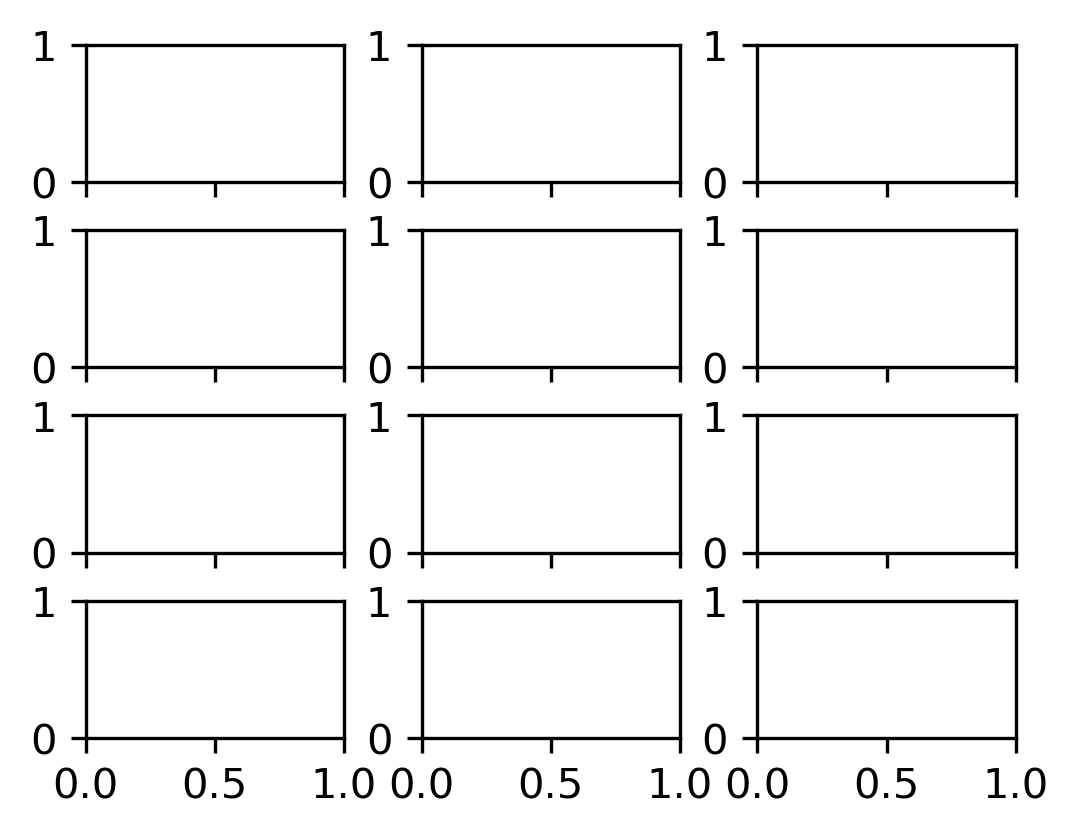

In [130]:
import seaborn as sns
matplotlib.style.use('default')

normalized_img_dir = Path("../NPC_Segmentation/72.RecurrentData/NormalizedFilesBySequence/Post/CE-T1W-FS_TRA/")
# normalized_img_dir = Path("../NPC_Segmentation/72.RecurrentData/NormalizedFilesBySequence/Pre/CE-T1W-FS_TRA/")
pred_mal_patches = {}

plt_data = []
for pid, (_, df_post_grid) in df_dict.items():
    if pid not in best_model.keys():
        continue
    model = best_model[pid]
    
    # Post-treatment X, y
    y_post = ~df_post_grid[vic_status_idx] # vicinity considered as non recurrent
    x_post = df_post_grid.drop(['diagnostics', 'Extract Parameters'], axis=1)
    # X_post = x_post.values.astype('float') # * All features
    # X_post = x_post[list(fit_features[pid])].values.astype('float') # * Personalized features
    X_post = x_post[list(final_features)].values.astype('float') # * Common features

    # * Perform M w utest
    pred = model.predict(X_post)
    f, pval = ttest_ind(y_post, pred)

    # * Performance with ROC
    roc_auc = metrics.roc_auc_score(y_post, pred)
    
    _plot_data = y_post.to_frame()
    _plot_data.columns=['Malignant']
    _plot_data['Prediction'] = pred
    _plot_data['Patient'] = f"Patient {len(plt_data) + 1:02d} (AUC={roc_auc:.02f})"
    _plot_data['p-value'] = pval
    _plot_data['PID'] = pid
    _plot_data['AUC'] = roc_auc
    _plot_data.set_index('PID', append=True, inplace=True)
    plt_data.append(_plot_data)
    

plt_data = pd.concat(plt_data, axis=0)
display(plt_data)

plt_perf = plt_data[['p-value', 'AUC', 'Patient']].groupby(['Patient','PID']).mean()
display(plt_perf)

# Plot
palatte = ['r', 'g']
fig, ax = plt.subplots(4, 3, figsize=(4, 3), dpi=300, sharex=True, sharey=False, gridspec_kw={'hspace':.35, 'wspace':.3})
for i, _ax in enumerate(ax.flatten()):
    pid = f"Patient {i + 1}"
    sns.boxplot(plt_data[plt_data['Patient'] == f"Patient {i + 1}"], y='Prediction', x='Malignant',  
                hue='Malignant', dodge=False, fliersize=0.3, ax=_ax, palette='deep', width=0.4, linewidth=0.5)
    _ax.set_title(f"{pid.replace('Patient ', 'P')} ({float(plt_perf.loc[pid]['AUC']):.02f})", style='italic', fontsize=8)
    _ax.set_ylabel(None)
    _ax.set_xlabel(None)
    _ax.set_yticklabels(_ax.get_yticklabels(), fontsize=6)
    _ax.legend().remove() 
fig.supxlabel("Patch Is Malignant", fontsize=10, fontweight='bold')
fig.supylabel("Personalized Model Prediction", fontsize=10, fontweight='bold')
# fig.tight_layout()
plt.show()

/tmp/ipykernel_218895/3226796197.py:18: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right', fontsize=6)
/tmp/ipykernel_218895/3226796197.py:19: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels(ax.get_yticklabels(), fontsize=8)


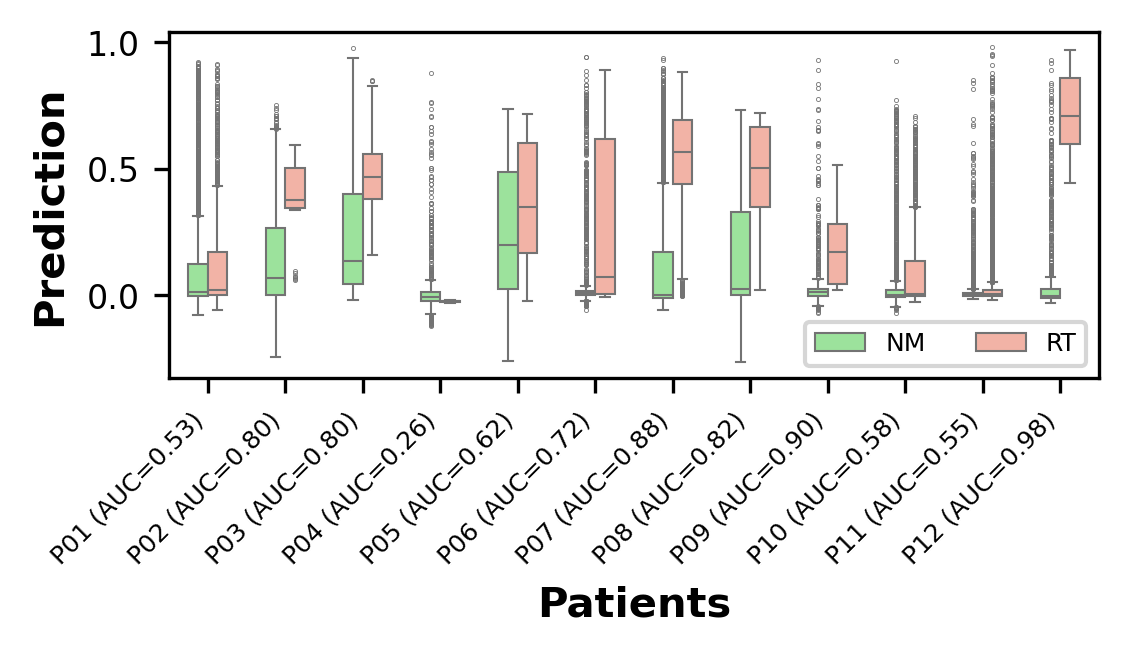

In [131]:

normalized_img_dir = Path("../NPC_Segmentation/72.RecurrentData/NormalizedFilesBySequence/Post/CE-T1W-FS_TRA/")
# normalized_img_dir = Path("../NPC_Segmentation/72.RecurrentData/NormalizedFilesBySequence/Pre/CE-T1W-FS_TRA/")
pred_mal_patches = {}

fig, ax = plt.subplots(1, 1, figsize=(4, 1.5), dpi=300)
plt_data_rev = plt_data.copy()
plt_data_rev['P'] = plt_data_rev['Patient'].apply(lambda x: x.replace('Patient ', 'P'))
plt_data_rev.sort_values('P', inplace=True)
plt_data_norm = []
for patient, perf in plt_data_rev.groupby('Patient'):
    plt_row = perf.copy()
    plt_row['Prediction'] = plt_row['Prediction'] / (plt_row['Prediction'].max() - plt_row['Prediction'].min())
    plt_data_norm.append(plt_row)
plt_data_norm = pd.concat(plt_data_norm, axis=0)
# scale based on patient
sns.boxplot(plt_data_norm, y='Prediction', hue='Malignant',  x='P', 
            dodge=True, fliersize=0.2, ax=ax, palette=['lightgreen','#FA9'], width=0.5, linewidth=0.5)
ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right', fontsize=6)
ax.set_yticklabels(ax.get_yticklabels(), fontsize=8)
ax.set_xlabel("Patients", fontweight='bold')
ax.set_ylabel("Prediction", fontweight='bold')
l = ax.legend(ncols=2, fontsize=6)
l.get_texts()[0].set_text('NM')
l.get_texts()[1].set_text('RT')
# l.remove()
# l.set_title("Malignancy")
# fig.tight_layout()
# l.remove()
# ax.set_title(f"{pid.replace('Patient ', 'P')} ({float(plt_perf.loc[pid]['AUC']):.02f})", style='italic', fontsize=8)
# ax.set_ylabel(None)
# ax.set_xlabel(None)
# ax.set_yticklabels(_ax.get_yticklabels(), fontsize=6)
# ax.legend().remove()
# fig.supxlabel("Patch Is Malignant", fontsize=10, fontweight='bold')
# fig.supylabel("Personalized Model Prediction", fontsize=10, fontweight='bold')
# fig.tight_layout()
plt.show()

In [55]:
# Average AUC
plt_perf = plt_data[['p-value', 'AUC', 'Patient']].groupby(['Patient','PID']).mean()
display(plt_perf.mean())
display(plt_perf.std())
display(plt_perf)

p-value    0.101434
AUC        0.702462
dtype: float64

p-value    0.196783
AUC        0.203627
dtype: float64

,,p-value,AUC
Patient,PID,,
Patient 1,FU109,6.960925e-80,0.525655
Patient 10,NPCR006,1.949328e-116,0.575515
Patient 11,NPCR009,0.000000e+00,0.552149
Patient 12,NPCR014,5.739669e-17,0.978563
Patient 2,FU185,9.529982e-29,0.796281
Patient 3,FU218,1.027578e-68,0.801881
Patient 4,FU293,1.636083e-03,0.255857
Patient 5,FU3,1.252798e-01,0.619702
Patient 6,FU485,9.173368e-02,0.722225


### Visulize the patches that are deemed positive

In [ ]:
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
from typing import List, Tuple, Union, Optional

df_post_raw[pred_casted].index.values
visualize_arr = index_to_visualize_arr(df_post_raw[pred_casted].index, 
                                       df_post_raw[pred_casted]['Patch Corner Coordinate'],
                                       df_post_raw[pred_casted]['Vicinity'])

slice_needs_draw = np.unique(visualize_arr[:, 0])

for i, slice_num in enumerate(slice_needs_draw):
    coords = visualize_arr[visualize_arr[:, 0] == slice_num]
    if all(coords[:, 3] != 0):
        continue
    fig, ax = plt.subplots(1,1, figsize=(10, 10))
    slice = test_img[slice_num]
    for j, patch in enumerate(coords):
        slice_num, x, y, v = patch
        ax.imshow(slice)
        rect = Rectangle((x, y), 16, 16, linewidth=1, edgecolor='r', facecolor='r', alpha=0.05)
        ax.add_patch(rect)
    plt.show()
    if i > 5:
        break

NameError: name 'pred_casted' is not defined